In [2]:
#Authors: Quentin Ludet, Carlos Moreno Acero, Charles Lee, Aline Hirsch

import requests
import json
import re

known_artists = {}

def get_genre(artist):
    formatted_artist = re.sub(r'\n| Duet|', '', artist)
    formatted_artist = re.sub(r' Feat | Featuring |, | With | And | X | x ', ' & ', formatted_artist)
    formatted_artist = re.split(' & ', formatted_artist)[0]
    formatted_artist
    if formatted_artist in known_artists:
      return known_artists[formatted_artist]
    url = f'https://api.getgenre.com/search?artist_name={formatted_artist.replace(" ", "+")}&analysis=2'

    session = requests.Session()
    session.mount(
        "https://api.getgenre.com",
        requests.adapters.HTTPAdapter(max_retries=10),
    )

    r = session.get(url, timeout=25)


    try:
      known_artists[formatted_artist] = r.json()['analysis']['all_genres'][0]
    except (KeyError, IndexError):
      known_artists[formatted_artist] = 'Not Found'
    except requests.exceptions.Timeout:
      print(f'timeout while searching for artist: {formatted_artist}')
      known_artists[formatted_artist] = 'Not Found'
    except json.decoder.JSONDecodeError:
      known_artists[formatted_artist] = 'Not Found'
      print('broken json:' + r.text)
    return known_artists[formatted_artist]

get_genre('Drake Featuring Doja Cat')

'pop'

In [18]:


class Song_Data:
  def __init__(self):
    self.dict = {}

  def add_song(self, song, artist, rank, date):
    if song in self.dict:
      self.dict[song][0].append((rank, date))
    else:
      self.dict[song] = ([(rank, date)], artist, get_genre(artist))

  def json(self):
    return json.dumps(self.dict, indent=4)

  def read_json(self, f):
    self.dict = json.load(f)

data = Song_Data()

In [4]:


from bs4 import BeautifulSoup
from datetime import date, timedelta

def song_list(date=''):

    url = f'https://www.billboard.com/charts/hot-100/{str(date)}'

    session = requests.Session()
    session.mount(
        "https://www.billboard.com",
        requests.adapters.HTTPAdapter(max_retries=5),
    )

    req = session.get(url, timeout=25)

    soup = BeautifulSoup(req.text, 'html.parser')

    song_e = soup.select('.c-title.a-no-trucate')

    artist_e = soup.select('.c-label.a-no-trucate')

    return list(zip([e.text.replace('\n', '').replace('\t', '') for e in song_e], [e.text.replace('\n', '').replace('\t', '') for e in artist_e]))


def all_sundays(year):
   d = date(year, 1, 1)                    # January 1st
   d += timedelta(days = 6 - d.weekday())  # First Sunday
   while d.year == year:
      yield d
      d += timedelta(days = 7)

def run_year(year):
  print(f'year {year}')
  for week_index, d in enumerate(all_sundays(year)):
      print(f'week {week_index+1}')
      songs = song_list(d)
      for i, (song, artist) in enumerate(songs):
        data.add_song((song + ' | ' + artist), artist, i+1, str(d))

In [5]:


def save_progress(year):
  with open('genres.json', 'w') as f:
    f.write(json.dumps(known_artists, indent=4))
  with open(f'song_data_{year}.json', 'w') as f:
    f.write(data.json())

In [19]:


try:
  for year in range(2011, 2023):
    run_year(year)
    save_progress(year)
except KeyboardInterrupt:
  print(f'found {len(data.dict)} songs so far')


year 2011
week 1
found 4 songs so far


In [22]:


import pandas as pd

df = pd.DataFrame(data.dict)
df.index = ['ranks', 'artist', 'genre']
df = df.T

df.head()

,ranks,artist,genre
Grenade | Bruno Mars,"[(1, 2011-01-02)]",Bruno Mars,pop
Firework | Katy Perry,"[(2, 2011-01-02)]",Katy Perry,pop
We R Who We R | Ke$ha,"[(3, 2011-01-02)]",Ke$ha,pop
What's My Name? | Rihanna Featuring Drake,"[(4, 2011-01-02)]",Rihanna Featuring Drake,pop


In [7]:

with open('song_data_final.json') as f:
    data = json.load(f)

In [8]:


import pandas as pd

g_data = pd.DataFrame({'genre':[],
                       '2011': [],
                       '2012': [],
                       '2013': [],
                       '2014': [],
                       '2015': [],
                       '2016': [],
                       '2017': [],
                       '2018': [],
                       '2019': [],
                       '2020': [],
                       '2021': [],
                       '2022': []}).set_index('genre')

In [9]:


for title, (ranks, artist, genre) in data.items():
    if genre not in g_data.index:
        g_data.loc[genre] = [0] * 12
    for rank in ranks:
        g_data.loc[genre][rank[1][:4]] += 101 - rank[0]

g_data.head()

,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
pop,78300,85814,69702,79625,100416,87429,83676,64355,71672,65457,73738,27120
teen pop,12048,2380,4256,6096,5264,1039,2649,534,0,13,249,0
trap,8308,7570,1923,8526,19286,11099,5474,5190,2094,5625,3767,2163
latin pop,2836,639,232,2042,0,104,4118,518,309,0,79,157
pop rap,24789,21956,9363,5107,7456,3380,357,472,261,2064,3517,162


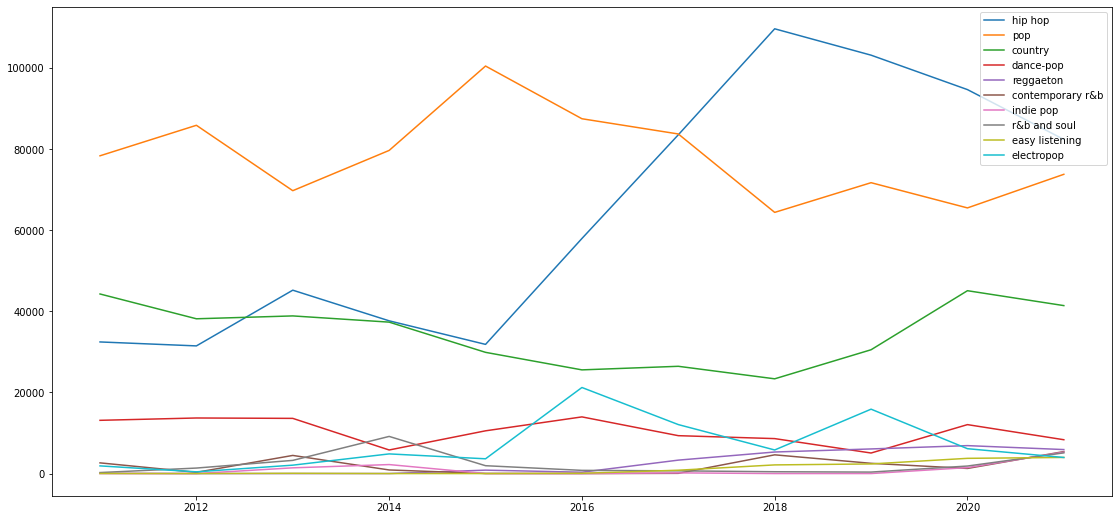

In [10]:


import matplotlib.pyplot as plt

x = range(2011, 2022)

plt.rcParams['figure.figsize'] = (19,9)
plt.rcParams['figure.facecolor'] = 'white'
for genre in g_data.sort_values(by='2021', ascending=False).index[:10]:
    plt.plot(x, g_data.loc[genre][:11], label = genre)
plt.legend()
plt.savefig('genre_trends.png')
plt.show()

In [11]:


import pandas as pd

a_data = pd.DataFrame({'artist':[],
                       '2011': [],
                       '2012': [],
                       '2013': [],
                       '2014': [],
                       '2015': [],
                       '2016': [],
                       '2017': [],
                       '2018': [],
                       '2019': [],
                       '2020': [],
                       '2021': [],
                       '2022': [],
                       'total': []}).set_index('artist')

In [12]:


import re

for title, (ranks, artist, genre) in data.items():
    artist = re.sub('\([^\)]*\)', '', artist)
    for a in re.split(' & | Featuring ', artist):
        if a not in a_data.index:
            a_data.loc[a] = [0] * 13
        for rank in ranks:
            a_data.loc[a][rank[1][:4]] += 101 - rank[0]
            a_data.loc[a]['total'] += 101 - rank[0]


a_data.head()

,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,total
Bruno Mars,9635,4768,7244,1173,4380,1061,6903,2104,1593,0,0,0,38861
Katy Perry,8484,5203,3607,7150,0,513,1371,81,2185,211,0,0,28805
Ke$ha,4971,1241,2853,2304,0,0,0,0,0,0,0,0,11369
Rihanna,9853,10849,6822,2683,3253,12031,5579,759,0,482,0,0,52311
Drake,9418,9329,7671,6250,12624,22119,7323,20972,8932,11584,12987,1687,130896


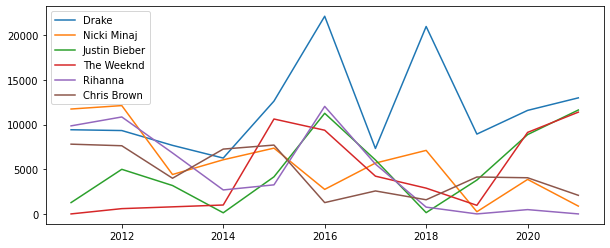

In [16]:


import matplotlib.pyplot as plt

x = range(2011, 2022)

plt.rcParams['figure.figsize'] = (10,4)
plt.rcParams['figure.facecolor'] = 'white'
for artist in a_data.sort_values(by='total', ascending=False).index[:6]:
    plt.plot(x, a_data.loc[artist][:11], label = artist)
plt.legend()
plt.savefig('artist_trends.png')
plt.show()

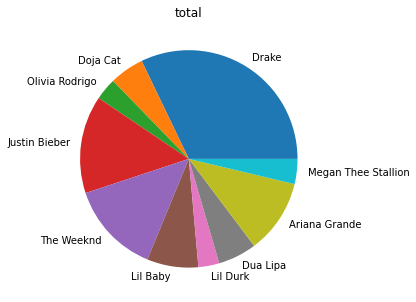

In [15]:


sorted_a = a_data.sort_values(by='total', ascending=False)
num_artists = 10

plt.rcParams['figure.figsize'] = (6,5)
plt.rcParams['figure.facecolor'] = 'white'


for year in range(2011, 2022):
    plt.clf()
    sorted_a = a_data.sort_values(by=str(year), ascending=False)
    plt.pie(sorted_a[str(year)][:num_artists], labels=sorted_a.index[:num_artists])
    plt.title(str(year))
    plt.savefig(f'pie/artists_{year}.png')

plt.clf()
plt.pie(sorted_a['total'][:num_artists], labels=sorted_a.index[:num_artists])
plt.title('total')
plt.show()

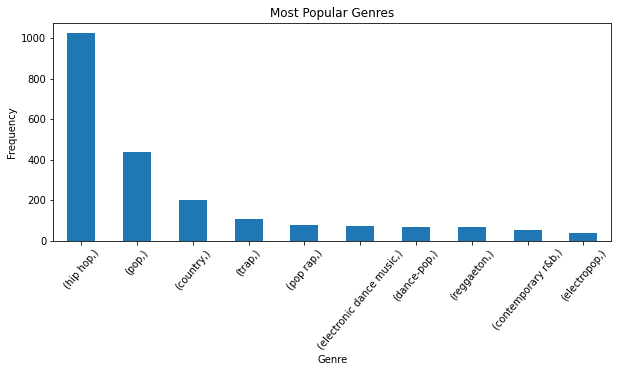

In [25]:


import pandas as pd
import json
from itertools import islice
from collections import Counter
import collections
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud


with open('song_data_final.json') as f:
    data = json.load(f)

genres = {}

for t in data.values():
  _, artist, genre =t
  genres[artist] = genre

genreslist = list(genres.values())


df = pd.DataFrame(genreslist)

df.value_counts().plot(kind='bar', xlabel='Genre', ylabel='Frequency')
plt.rcParams['figure.facecolor'] = 'white'
plt.title('Most Popular Genres')
plt.xlim(-0.5,9.5)
plt.xticks(rotation = 50)

plt.show()


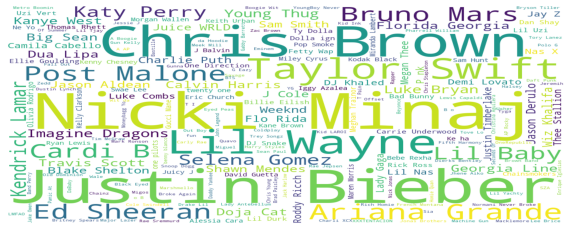

<Figure size 720x576 with 0 Axes>

In [33]:


import pandas as pd
import json
from itertools import islice
from collections import Counter
import collections
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib
import random

genres = {}

for t in data.values():
  _, artist, genre =t
  genres[artist] = genre

#artistlist = list(genres.keys())

artist_list = []
for x in a_data.index:
  for i in range(a_data.loc[x]['total']):
    artist_list.append(x)

random.shuffle(artist_list)

artiststr = ' '.join(artist_list)
stop_words = ["featuring", "featuring chris", "the","with"]
wordcloud = WordCloud(stopwords = stop_words, width=1000, height=600, background_color = "white").generate(artiststr)

plt.imshow(wordcloud,  aspect="auto")
plt.axis("off")
plt.figure(figsize=[10,8])
plt.show()

wordcloud.to_file('wordcloud.png')


In [38]:


import json
import pandas as pd

f = open('song_data_final.json')

data = json.load(f)


# This takes a data from the JSON file and finds the artist. It returns the most played song by year.
def input_data():
    artist_name = input('Enter the name of the artist you would like to find ')
    rank = []
    artist = []
    genre = []

    for song in data:

        if artist_name in data[song][1]:
            rank.append(data[song][0])
            artist.append(data[song][1])
            genre.append(data[song][2])

    output = ranking_builder(rank, artist)
    return output

# This function creates a data frame with the artist songs and times it ranked in the board. 
def ranking_builder(ranking, artist):
    date = []
    place = []
    count = 0

    for song in ranking:
        for times in song:
            date.append(times[1])
            place.append(times[0])
            count += 1
    df = pd.DataFrame(place, date, columns=['Ranking'])
    print(artist[0], 'Appears in the chart', count, 'times.')
    return df


printout = input_data()

print(printout)
f.close()


Bruno Mars Appears in the chart 621 times.
            Ranking
2011-01-02        1
2011-01-09        2
2011-01-16        1
2011-01-23        2
2011-01-30        1
...             ...
2022-03-27       78
2021-11-21       68
2021-11-21       73
2021-11-21       78
2021-11-21       81

[621 rows x 1 columns]
